In [254]:
import os
import warnings

import lightgbm as lgb

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm

In [255]:
# Set the path to the file you'd like to load
# file_path = "https://drive.google.com/drive/folders/1eerGUzfwDOzEryn9MIM7P5alvS4U_gw3/merged_appa_eea.csv:"
file_path = "../data/merged_appa_eea_daily.csv"

df = pd.read_csv(file_path)

print("First 5 records:", df.head())

First 5 records:      Stazione        Data Inquinante Unità di misura  Latitudine  Longitudine  \
0  A22 (Avio)  2013-01-01       PM10          ug.m-3    45.74215     10.97043   
1  A22 (Avio)  2013-01-02       PM10          ug.m-3    45.74215     10.97043   
2  A22 (Avio)  2013-01-03       PM10          ug.m-3    45.74215     10.97043   
3  A22 (Avio)  2013-01-04       PM10          ug.m-3    45.74215     10.97043   
4  A22 (Avio)  2013-01-05       PM10          ug.m-3    45.74215     10.97043   

      Valore Nazione Comune StazioneMeteo  ...  Veneto_MA_17_min_lon  \
0  31.250000   Italy   APPA         T0153  ...             13.036699   
1  36.208333   Italy   APPA         T0153  ...             13.036699   
2  22.083333   Italy   APPA         T0153  ...             13.036699   
3  19.166667   Italy   APPA         T0153  ...             13.036699   
4  24.375000   Italy   APPA         T0153  ...             13.036699   

   Veneto_MA_17_max_lat  Veneto_MA_17_max_lon  Veneto_MA_17_Uni

/tmp/ipykernel_19106/1062250780.py:5: DtypeWarning: Columns (215) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [256]:
df = df[df['Inquinante'] == 'PM10'].copy()
display(df.head())
print(df.shape)

stations_dfs = {station: data for station, data in df.groupby('Stazione')}

for elem in stations_dfs:
  print(elem)
  #print(stations_dfs[elem].head())
  print(stations_dfs[elem].shape)
  #print(stations_dfs[elem].dtypes)


,Stazione,Data,Inquinante,Unità di misura,Latitudine,Longitudine,Valore,Nazione,Comune,StazioneMeteo,...,Veneto_MA_17_min_lon,Veneto_MA_17_max_lat,Veneto_MA_17_max_lon,Veneto_MA_17_Unità di misura,Veneto_MA_18_Valore_medio_microarea,Veneto_MA_18_min_lat,Veneto_MA_18_min_lon,Veneto_MA_18_max_lat,Veneto_MA_18_max_lon,Veneto_MA_18_Unità di misura
0,A22 (Avio),2013-01-01,PM10,ug.m-3,45.74215,10.97043,31.250000,Italy,APPA,T0153,...,13.036699,46.262019,13.524038,ug.m-3,50.0,46.262019,10.6,46.749359,11.08734,ug.m-3
1,A22 (Avio),2013-01-02,PM10,ug.m-3,45.74215,10.97043,36.208333,Italy,APPA,T0153,...,13.036699,46.262019,13.524038,ug.m-3,32.0,46.262019,10.6,46.749359,11.08734,ug.m-3
2,A22 (Avio),2013-01-03,PM10,ug.m-3,45.74215,10.97043,22.083333,Italy,APPA,T0153,...,13.036699,46.262019,13.524038,ug.m-3,30.0,46.262019,10.6,46.749359,11.08734,ug.m-3
3,A22 (Avio),2013-01-04,PM10,ug.m-3,45.74215,10.97043,19.166667,Italy,APPA,T0153,...,13.036699,46.262019,13.524038,ug.m-3,16.0,46.262019,10.6,46.749359,11.08734,ug.m-3
4,A22 (Avio),2013-01-05,PM10,ug.m-3,45.74215,10.97043,24.375000,Italy,APPA,T0153,...,13.036699,46.262019,13.524038,ug.m-3,2.0,46.262019,10.6,46.749359,11.08734,ug.m-3


(34302, 216)
A22 (Avio)
(3965, 216)
Borgo Valsugana
(4343, 216)
Monte Gaza
(4291, 216)
Parco S. Chiara
(4377, 216)
Piana Rotaliana
(4272, 216)
Riva del Garda
(4349, 216)
Rovereto
(4338, 216)
Via Bolzano
(4367, 216)


In [257]:
for elem in stations_dfs:
  print(elem)
  #print(stations_dfs[elem].head())
  print(stations_dfs[elem].shape)
  #print(stations_dfs[elem].dtypes)

A22 (Avio)
(3965, 216)
Borgo Valsugana
(4343, 216)
Monte Gaza
(4291, 216)
Parco S. Chiara
(4377, 216)
Piana Rotaliana
(4272, 216)
Riva del Garda
(4349, 216)
Rovereto
(4338, 216)
Via Bolzano
(4367, 216)


In [258]:
# Apply datetime parsing and feature engineering
for station, data in stations_dfs.items():
    data['Data'] = pd.to_datetime(data['Data'], format="%Y-%m-%d")
    #data['datetime'] = data['Data'] + pd.to_timedelta(data['Ora'], unit='h')


# Reindex to have a complete time series
for station, data in stations_dfs.items():
    # Create a complete time range for the station
    if 'Data' in data.columns:
        start_time = data['Data'].min()
        end_time = data['Data'].max()
        data = data.set_index('Data', drop=False) # Keep datetime as a column
    else: # datetime is already the index
        start_time = data.index.min()
        end_time = data.index.max()

    all_hours = pd.date_range(start=start_time, end=end_time, freq='d')

    # Reindex the data with the complete time range
    stations_dfs[station] = data.reindex(all_hours)

# Display shapes to confirm
for elem in stations_dfs:
  print(elem)
  print(stations_dfs[elem].shape)

stations_dfs["Parco S. Chiara"].head(5)

A22 (Avio)
(4384, 216)
Borgo Valsugana
(4384, 216)
Monte Gaza
(4382, 216)
Parco S. Chiara
(4384, 216)
Piana Rotaliana
(4384, 216)
Riva del Garda
(4384, 216)
Rovereto
(4384, 216)
Via Bolzano
(4384, 216)


,Stazione,Data,Inquinante,Unità di misura,Latitudine,Longitudine,Valore,Nazione,Comune,StazioneMeteo,...,Veneto_MA_17_min_lon,Veneto_MA_17_max_lat,Veneto_MA_17_max_lon,Veneto_MA_17_Unità di misura,Veneto_MA_18_Valore_medio_microarea,Veneto_MA_18_min_lat,Veneto_MA_18_min_lon,Veneto_MA_18_max_lat,Veneto_MA_18_max_lon,Veneto_MA_18_Unità di misura
2013-01-01,Parco S. Chiara,2013-01-01,PM10,ug.m-3,46.06292,11.1262,45.500000,Italy,APPA,T0129,...,13.036699,46.262019,13.524038,ug.m-3,50.0,46.262019,10.6,46.749359,11.08734,ug.m-3
2013-01-02,Parco S. Chiara,2013-01-02,PM10,ug.m-3,46.06292,11.1262,37.833333,Italy,APPA,T0129,...,13.036699,46.262019,13.524038,ug.m-3,32.0,46.262019,10.6,46.749359,11.08734,ug.m-3
2013-01-03,Parco S. Chiara,2013-01-03,PM10,ug.m-3,46.06292,11.1262,20.666667,Italy,APPA,T0129,...,13.036699,46.262019,13.524038,ug.m-3,30.0,46.262019,10.6,46.749359,11.08734,ug.m-3
2013-01-04,Parco S. Chiara,2013-01-04,PM10,ug.m-3,46.06292,11.1262,32.791667,Italy,APPA,T0129,...,13.036699,46.262019,13.524038,ug.m-3,16.0,46.262019,10.6,46.749359,11.08734,ug.m-3
2013-01-05,Parco S. Chiara,2013-01-05,PM10,ug.m-3,46.06292,11.1262,18.875000,Italy,APPA,T0129,...,13.036699,46.262019,13.524038,ug.m-3,2.0,46.262019,10.6,46.749359,11.08734,ug.m-3


In [259]:
for station, data in stations_dfs.items():
    data['Anno']  = data['Data'].dt.year
    data['Mese'] = data['Data'].dt.month
    data['Giorno']   = data['Data'].dt.day
    data['dow']   = data['Data'].dt.dayofweek
    # cyclical
    data['Mese_sin'] = np.sin(2*np.pi*data['Mese']/12)
    data['Mese_cos'] = np.cos(2*np.pi*data['Mese']/12)
    data['dow_sin'] = np.sin(2*np.pi*data['dow']/7)
    data['dow_cos'] = np.cos(2*np.pi*data['dow']/7)

    stations_dfs[station] = data.drop(['dow'], axis=1, inplace=False)

In [260]:
# Dictionary of old and new column names
new_column_names = {
    'Stazione': 'Station',
    'Inquinante': 'Pollutant',
    'Data': 'Datetime',
    'Valore': 'PM10',
    'Unità di misura': 'Unit of Measure',
    'Latitudine': 'Latitude',
    'Longitudine': 'Longitude',
    'Nazione': 'Country',
    'Comune': 'Municipality',
    'Pioggia_value': 'Rain',
    # 'Pioggia (mm).1': 'Rain.1',
    'Temp. aria (°C)': 'Air Temp',
    'Temperatura_aria_value': 'Air Temp.1',
    # 'Temp. aria (°C).2': 'Air Temp.2',
    'Umid.relativa_aria_value': 'Humidity',
    'Pressione_atmosferica_value': 'Pressure',
    'Direzione_vento_media_value': 'Wind Direction',
    'Veloc._vento_media_value': 'Wind Speed',
    'Radiazione_solare_totale_value': 'Radiation',
    'Anno': 'Year',
    'Giorno': 'Day',
    'Mese': 'Month'

}


for station, data in stations_dfs.items():
    stations_dfs[station] = data.rename(columns=new_column_names)
    stations_dfs[station].drop(['Unit of Measure', 'Country', 'Municipality','Pollutant','Latitude','Longitude'], axis=1, inplace=True)
    
# Display the columns of one dataframe to verify
for station, data in stations_dfs.items():
    print(f"Columns of {station} after renaming:")
    print(stations_dfs[station].columns)


Columns of A22 (Avio) after renaming:
Index(['Station', 'Datetime', 'PM10', 'StazioneMeteo', 'Rain', 'Air Temp',
       'Humidity', 'Wind Direction', 'Wind Speed', 'Pressure',
       ...
       'Veneto_MA_18_max_lat', 'Veneto_MA_18_max_lon',
       'Veneto_MA_18_Unità di misura', 'Year', 'Month', 'Day', 'Mese_sin',
       'Mese_cos', 'dow_sin', 'dow_cos'],
      dtype='object', length=217)
Columns of Borgo Valsugana after renaming:
Index(['Station', 'Datetime', 'PM10', 'StazioneMeteo', 'Rain', 'Air Temp',
       'Humidity', 'Wind Direction', 'Wind Speed', 'Pressure',
       ...
       'Veneto_MA_18_max_lat', 'Veneto_MA_18_max_lon',
       'Veneto_MA_18_Unità di misura', 'Year', 'Month', 'Day', 'Mese_sin',
       'Mese_cos', 'dow_sin', 'dow_cos'],
      dtype='object', length=217)
Columns of Monte Gaza after renaming:
Index(['Station', 'Datetime', 'PM10', 'StazioneMeteo', 'Rain', 'Air Temp',
       'Humidity', 'Wind Direction', 'Wind Speed', 'Pressure',
       ...
       'Veneto_MA_18_m

In [261]:
for station, data in stations_dfs.items():
    data['Wind_u'] = data['Wind Speed'] * np.sin(np.deg2rad(data['Wind Direction']))
    data['Wind_v'] = data['Wind Speed'] * np.cos(np.deg2rad(data['Wind Direction']))

    stations_dfs[station] = data.drop(['Wind Direction', 'Wind Speed'], axis=1, inplace=False)

# Display the columns of one dataframe to verify
for station, data in stations_dfs.items():
    print(f"Columns of {station} after transformation:")
    print(stations_dfs[station].columns)
    break # Only print for one station for brevity

Columns of A22 (Avio) after transformation:
Index(['Station', 'Datetime', 'PM10', 'StazioneMeteo', 'Rain', 'Air Temp',
       'Humidity', 'Pressure', 'Radiation', 'Air Temp.1',
       ...
       'Veneto_MA_18_Unità di misura', 'Year', 'Month', 'Day', 'Mese_sin',
       'Mese_cos', 'dow_sin', 'dow_cos', 'Wind_u', 'Wind_v'],
      dtype='object', length=217)


In [262]:
# Create lagged features for specific columns with a lag of 6 hours
lag_period = 1

# Update column names to match the renamed columns in your dataframes
cols_to_lag = ['Radiation','Air Temp', 'Air Temp.1', 'Humidity', 'Pressure', 'Wind_u', 'Wind_v','PM10','Rain']
for station, data in stations_dfs.items():
    for col in stations_dfs[station].columns:
        if 'Valore_medio_microarea' in col:
            cols_to_lag.append(col)


for station, data in stations_dfs.items():
    for col in cols_to_lag:
        data[f'{col}_lag_{lag_period}'] = data[col].shift(lag_period)
    stations_dfs[station] = data


# Display the head of one dataframe to verify
first_station = list(stations_dfs.keys())[0]
display(stations_dfs[first_station].head(10))

,Station,Datetime,PM10,StazioneMeteo,Rain,Air Temp,Humidity,Pressure,Radiation,Air Temp.1,...,Veneto_MA_8_Valore_medio_microarea_lag_1,Veneto_MA_9_Valore_medio_microarea_lag_1,Veneto_MA_11_Valore_medio_microarea_lag_1,Veneto_MA_12_Valore_medio_microarea_lag_1,Veneto_MA_13_Valore_medio_microarea_lag_1,Veneto_MA_14_Valore_medio_microarea_lag_1,Veneto_MA_15_Valore_medio_microarea_lag_1,Veneto_MA_16_Valore_medio_microarea_lag_1,Veneto_MA_17_Valore_medio_microarea_lag_1,Veneto_MA_18_Valore_medio_microarea_lag_1
2013-01-01,A22 (Avio),2013-01-01,31.250000,T0153,4.4,1.6,NaN,936.3,2306.4,2.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,A22 (Avio),2013-01-02,36.208333,T0153,3.9,1.5,NaN,940.6,163.0,2.95,...,109.4,136.0,NaN,-307.333333,47.00,60.0,45.75,NaN,49.71873,50.0
2013-01-03,A22 (Avio),2013-01-03,22.083333,T0153,0.7,2.5,NaN,951.1,1825.2,6.70,...,50.4,51.8,NaN,-306.666667,47.00,69.0,31.75,NaN,25.55212,32.0
2013-01-04,A22 (Avio),2013-01-04,19.166667,T0153,0.0,8.0,NaN,947.2,1768.1,9.35,...,39.8,36.8,NaN,-321.000000,25.75,46.0,29.75,NaN,-999.00000,30.0
2013-01-05,A22 (Avio),2013-01-05,24.375000,T0153,0.0,9.9,NaN,940.9,1622.1,11.10,...,71.4,68.0,NaN,-315.333333,42.75,48.0,42.00,NaN,45.07936,16.0
2013-01-06,A22 (Avio),2013-01-06,17.000000,T0153,0.0,9.5,NaN,939.3,1813.6,9.05,...,94.2,-104.0,NaN,-320.333333,23.25,53.0,73.50,NaN,46.98497,2.0
2013-01-07,A22 (Avio),2013-01-07,79.250000,T0153,0.0,8.1,NaN,940.0,1653.2,8.20,...,-55.4,257.8,NaN,-307.000000,22.75,55.0,116.00,NaN,64.07814,1.0
2013-01-08,A22 (Avio),2013-01-08,77.625000,T0153,0.0,3.2,NaN,943.0,1522.0,3.10,...,-112.2,121.4,NaN,-286.333333,49.00,51.0,31.50,NaN,51.62287,3.0
2013-01-09,A22 (Avio),2013-01-09,47.708333,T0153,0.0,2.7,NaN,939.9,2597.6,2.95,...,-163.2,37.8,NaN,-296.000000,55.25,58.0,40.25,NaN,46.64223,19.0
2013-01-10,A22 (Avio),2013-01-10,58.458333,T0153,0.0,2.4,NaN,931.6,2207.8,2.25,...,73.2,88.8,NaN,-304.000000,46.50,55.0,48.75,NaN,48.89160,40.0


In [263]:
train_dfs = {}
test_dfs = {}

equal_features = ['Datetime','Ora_sin','Ora_cos','Mese_sin','Mese_cos','dow_sin','dow_cos', 'Year', 'Station','Date','Hour','StazioneMeteo']
different_features = []
total_train_dfs = pd.DataFrame()
total_test_dfs = pd.DataFrame()

for station, data in stations_dfs.items():
   for col in stations_dfs[station].columns:
       if "Veneto" in col or "Lombardia" in col:
          if col not in equal_features:
               equal_features.append(col)
           # print(col)

print(f"equal_features: {equal_features}")

for station, data in stations_dfs.items():
    train_dfs[station] = data[data['Year'] < 2024].copy()
    test_dfs[station] = data[data['Year'] >= 2024].copy()
    different_features = list(set(train_dfs[station]) - set(equal_features))
    # print(f"different_features: {different_features}")
    # print(len(different_features))

    for feature in different_features:
      train_dfs[station].rename(columns={feature: f"{station}_{feature}"}, inplace=True)
      test_dfs[station].rename(columns={feature: f"{station}_{feature}"}, inplace=True)

    total_train_dfs = pd.concat([total_train_dfs, train_dfs[station]], axis=1)
    total_train_dfs = total_train_dfs.loc[:, ~total_train_dfs.columns.duplicated()]
    total_test_dfs = pd.concat([total_test_dfs, test_dfs[station]], axis=1)
    total_test_dfs = total_test_dfs.loc[:, ~total_test_dfs.columns.duplicated()]

for station in train_dfs:
  #print(X_train_dfs[station].shape)
  train_dfs[station] = total_train_dfs
  print(train_dfs[station].shape)
  # print(train_dfs[station].columns)
  #print(X_train_dfs[station].head())

for station in test_dfs:
  #print(X_test_dfs[station].shape)
  test_dfs[station] = total_test_dfs
  print(test_dfs[station].shape)
  #print(X_test_dfs[station].head())

display(train_dfs[first_station].head(10))


equal_features: ['Datetime', 'Ora_sin', 'Ora_cos', 'Mese_sin', 'Mese_cos', 'dow_sin', 'dow_cos', 'Year', 'Station', 'Date', 'Hour', 'StazioneMeteo', 'Lombardia_MA_0_Valore_medio_microarea', 'Lombardia_MA_0_min_lat', 'Lombardia_MA_0_min_lon', 'Lombardia_MA_0_max_lat', 'Lombardia_MA_0_max_lon', 'Lombardia_MA_0_Unità di misura', 'Lombardia_MA_1_Valore_medio_microarea', 'Lombardia_MA_1_min_lat', 'Lombardia_MA_1_min_lon', 'Lombardia_MA_1_max_lat', 'Lombardia_MA_1_max_lon', 'Lombardia_MA_1_Unità di misura', 'Lombardia_MA_2_Valore_medio_microarea', 'Lombardia_MA_2_min_lat', 'Lombardia_MA_2_min_lon', 'Lombardia_MA_2_max_lat', 'Lombardia_MA_2_max_lon', 'Lombardia_MA_2_Unità di misura', 'Lombardia_MA_3_Valore_medio_microarea', 'Lombardia_MA_3_min_lat', 'Lombardia_MA_3_min_lon', 'Lombardia_MA_3_max_lat', 'Lombardia_MA_3_max_lon', 'Lombardia_MA_3_Unità di misura', 'Lombardia_MA_4_Valore_medio_microarea', 'Lombardia_MA_4_min_lat', 'Lombardia_MA_4_min_lon', 'Lombardia_MA_4_max_lat', 'Lombardia_MA_4_

,Station,Datetime,A22 (Avio)_PM10,StazioneMeteo,A22 (Avio)_Rain,A22 (Avio)_Air Temp,A22 (Avio)_Humidity,A22 (Avio)_Pressure,A22 (Avio)_Radiation,A22 (Avio)_Air Temp.1,...,Via Bolzano_Wind_v,Via Bolzano_Radiation_lag_1,Via Bolzano_Air Temp_lag_1,Via Bolzano_Air Temp.1_lag_1,Via Bolzano_Humidity_lag_1,Via Bolzano_Pressure_lag_1,Via Bolzano_Wind_u_lag_1,Via Bolzano_Wind_v_lag_1,Via Bolzano_PM10_lag_1,Via Bolzano_Rain_lag_1
2013-01-01,A22 (Avio),2013-01-01,31.250000,T0153,4.4,1.6,NaN,936.3,2306.4,2.45,...,0.534604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,A22 (Avio),2013-01-02,36.208333,T0153,3.9,1.5,NaN,940.6,163.0,2.95,...,0.779496,6641.7,-0.6,0.30,84.1,991.8,-0.272394,0.534604,57.363636,0.2
2013-01-03,A22 (Avio),2013-01-03,22.083333,T0153,0.7,2.5,NaN,951.1,1825.2,6.70,...,0.970296,2887.1,1.9,2.55,89.8,996.3,-0.179961,0.779496,49.250000,0.1
2013-01-04,A22 (Avio),2013-01-04,19.166667,T0153,0.0,8.0,NaN,947.2,1768.1,9.35,...,0.593634,6776.5,1.7,3.50,77.5,1007.5,-0.241922,0.970296,34.916667,0.0
2013-01-05,A22 (Avio),2013-01-05,24.375000,T0153,0.0,9.9,NaN,940.9,1622.1,11.10,...,1.278964,6398.4,1.3,7.75,85.0,1003.1,-0.370943,0.593634,58.333333,0.0
2013-01-06,A22 (Avio),2013-01-06,17.000000,T0153,0.0,9.5,NaN,939.3,1813.6,9.05,...,0.798636,7209.5,7.0,7.75,67.3,995.2,-0.569431,1.278964,32.500000,0.0
2013-01-07,A22 (Avio),2013-01-07,79.250000,T0153,0.0,8.1,NaN,940.0,1653.2,8.20,...,0.317952,6551.6,5.9,6.95,69.0,993.8,-0.601815,0.798636,38.000000,0.0
2013-01-08,A22 (Avio),2013-01-08,77.625000,T0153,0.0,3.2,NaN,943.0,1522.0,3.10,...,-0.477399,7393.1,5.1,6.25,66.8,994.3,-0.508829,0.317952,79.166667,0.0
2013-01-09,A22 (Avio),2013-01-09,47.708333,T0153,0.0,2.7,NaN,939.9,2597.6,2.95,...,0.822191,5551.7,2.4,3.05,85.9,998.1,-0.511948,-0.477399,82.333333,0.0
2013-01-10,A22 (Avio),2013-01-10,58.458333,T0153,0.0,2.4,NaN,931.6,2207.8,2.25,...,0.676148,5833.4,4.4,4.05,78.5,994.9,-0.366063,0.822191,58.958333,0.0


In [264]:
from re import X

X_train_dfs = {}
y_train_dfs = {}
X_test_dfs = {}
y_test_dfs = {}

#features = ['Ora_sin','Ora_cos','Mese_sin','Mese_cos','dow_sin','dow_cos','Year']
features_to_ignore = ['Datetime','Station', 'Hour', 'StazioneMeteo', 'Month']
for col in total_test_dfs.columns:
    if "Veneto" in col or "Lombardia" in col:
        if f'Valore_medio_microarea_lag_{lag_period}' not in col:
            features_to_ignore.append(col)
print(len(features_to_ignore))

features = list(set(total_test_dfs.columns) - set(features_to_ignore))

features_to_remove = []
for station, data in stations_dfs.items():
    features_to_remove.append(f'{station}_PM10')

features = list(set(features)-set(features_to_remove))
            
features.sort()
print(len(features))
print(features)

for station, data in stations_dfs.items():
  target = [f'{station}_PM10']

  print(target)
  # Create X and y for train and test sets
  train_dfs[station] = train_dfs[station].loc[:, ~train_dfs[station].columns.duplicated()]
  test_dfs[station] = test_dfs[station].loc[:, ~test_dfs[station].columns.duplicated()]
  X_train_dfs[station] = train_dfs[station][features]
  y_train_dfs[station] = train_dfs[station][target]
  X_test_dfs[station] = test_dfs[station][features]
  y_test_dfs[station] = test_dfs[station][target]


  print(f"Station: {station}")
  print("Train shape:", train_dfs[station].shape)
  print("Test shape:", test_dfs[station].shape)
  print("X_train shape:", X_train_dfs[station].shape)
  print("y_train shape:", y_train_dfs[station].shape)
  print("X_test shape:", X_test_dfs[station].shape)
  print("y_test shape:", y_test_dfs[station].shape)

#   # Define features and target





203
190
['A22 (Avio)_Air Temp', 'A22 (Avio)_Air Temp.1', 'A22 (Avio)_Air Temp.1_lag_1', 'A22 (Avio)_Air Temp_lag_1', 'A22 (Avio)_Day', 'A22 (Avio)_Humidity', 'A22 (Avio)_Humidity_lag_1', 'A22 (Avio)_Month', 'A22 (Avio)_PM10_lag_1', 'A22 (Avio)_Pressure', 'A22 (Avio)_Pressure_lag_1', 'A22 (Avio)_Radiation', 'A22 (Avio)_Radiation_lag_1', 'A22 (Avio)_Rain', 'A22 (Avio)_Rain_lag_1', 'A22 (Avio)_Wind_u', 'A22 (Avio)_Wind_u_lag_1', 'A22 (Avio)_Wind_v', 'A22 (Avio)_Wind_v_lag_1', 'Borgo Valsugana_Air Temp', 'Borgo Valsugana_Air Temp.1', 'Borgo Valsugana_Air Temp.1_lag_1', 'Borgo Valsugana_Air Temp_lag_1', 'Borgo Valsugana_Day', 'Borgo Valsugana_Humidity', 'Borgo Valsugana_Humidity_lag_1', 'Borgo Valsugana_Month', 'Borgo Valsugana_PM10_lag_1', 'Borgo Valsugana_Pressure', 'Borgo Valsugana_Pressure_lag_1', 'Borgo Valsugana_Radiation', 'Borgo Valsugana_Radiation_lag_1', 'Borgo Valsugana_Rain', 'Borgo Valsugana_Rain_lag_1', 'Borgo Valsugana_Wind_u', 'Borgo Valsugana_Wind_u_lag_1', 'Borgo Valsugana

In [265]:
trained_models = {}

# Best parameters found (as provided by the user)
#best_params = {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 31}

for station in stations_dfs.keys():
    print(f"Training model for {station}...")
    #model = lgb.LGBMRegressor(**best_params)
    model = lgb.LGBMRegressor()
    model.fit(X_train_dfs[station], y_train_dfs[station].values.ravel()) # .values.ravel() to avoid reshape warning

    trained_models[station] = model
    print(f"Model for {station} trained.")

print("\nTraining complete for all stations.")

Training model for A22 (Avio)...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42781
[LightGBM] [Info] Number of data points in the train set: 4017, number of used features: 190
[LightGBM] [Info] Start training from score 17.559409
Model for A22 (Avio) trained.
Training model for Borgo Valsugana...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42781
[LightGBM] [Info] Number of data points in the train set: 4017, number of used features: 190
[LightGBM] [Info] Start training from score 22.993905
Model for Borgo Valsugana trained.
Training model f

In [266]:
import time

predictions_dfs = {}
prediction_times = {}

for station, model in trained_models.items():
    print(f"Making predictions for {station}...")
    start_time = time.time()
    predictions = model.predict(X_test_dfs[station])
    end_time = time.time()

    predictions_dfs[station] = predictions
    prediction_times[station] = end_time - start_time

    print(f"Predictions made for {station}. Time taken: {prediction_times[station]:.4f} seconds")

print("\nPrediction complete for all stations.")

Making predictions for A22 (Avio)...
Predictions made for A22 (Avio). Time taken: 0.0031 seconds
Making predictions for Borgo Valsugana...
Predictions made for Borgo Valsugana. Time taken: 0.0023 seconds
Making predictions for Monte Gaza...
Predictions made for Monte Gaza. Time taken: 0.0021 seconds
Making predictions for Parco S. Chiara...
Predictions made for Parco S. Chiara. Time taken: 0.0013 seconds
Making predictions for Piana Rotaliana...
Predictions made for Piana Rotaliana. Time taken: 0.0015 seconds
Making predictions for Riva del Garda...
Predictions made for Riva del Garda. Time taken: 0.0012 seconds
Making predictions for Rovereto...
Predictions made for Rovereto. Time taken: 0.0012 seconds
Making predictions for Via Bolzano...
Predictions made for Via Bolzano. Time taken: 0.0012 seconds

Prediction complete for all stations.


In [267]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

evaluation_metrics = {}

for station in stations_dfs.keys():
    # Ensure y_test is a 1D array for metric calculation
    y_true = y_test_dfs[station].values.ravel()
    y_pred = predictions_dfs[station]

    # Create a mask to filter out NaN values from both arrays
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]

    # Only calculate metrics if there are valid data points
    if len(y_true_clean) > 0:
        mae = mean_absolute_error(y_true_clean, y_pred_clean)
        rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))

        evaluation_metrics[station] = {'MAE': mae, 'RMSE': rmse}

        print(f"Evaluation for {station}:")
        print(f"  MAE: {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  Valid data points: {len(y_true_clean)}/{len(y_true)}")
    else:
        print(f"Warning: No valid data points for {station}")
        evaluation_metrics[station] = {'MAE': np.nan, 'RMSE': np.nan}

print("\nEvaluation complete for all stations.")

Evaluation for A22 (Avio):
  MAE: 3.7506
  RMSE: 5.4700
  Valid data points: 293/367
Evaluation for Borgo Valsugana:
  MAE: 4.0140
  RMSE: 5.9949
  Valid data points: 361/367
Evaluation for Monte Gaza:
  MAE: 3.6861
  RMSE: 8.4423
  Valid data points: 364/367
Evaluation for Parco S. Chiara:
  MAE: 2.9489
  RMSE: 4.5148
  Valid data points: 364/367
Evaluation for Piana Rotaliana:
  MAE: 3.0161
  RMSE: 4.4498
  Valid data points: 367/367
Evaluation for Riva del Garda:
  MAE: 3.5711
  RMSE: 6.4569
  Valid data points: 366/367
Evaluation for Rovereto:
  MAE: 3.5779
  RMSE: 5.0647
  Valid data points: 355/367
Evaluation for Via Bolzano:
  MAE: 3.6060
  RMSE: 5.4270
  Valid data points: 367/367

Evaluation complete for all stations.


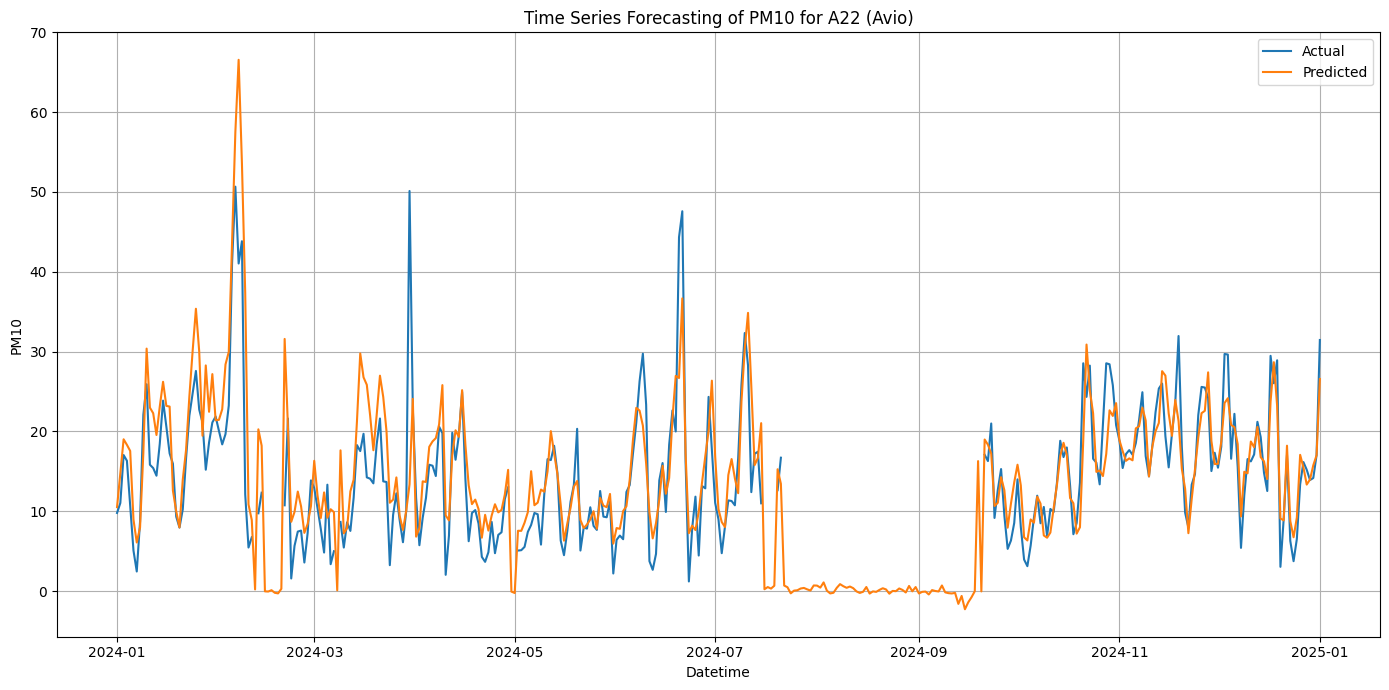

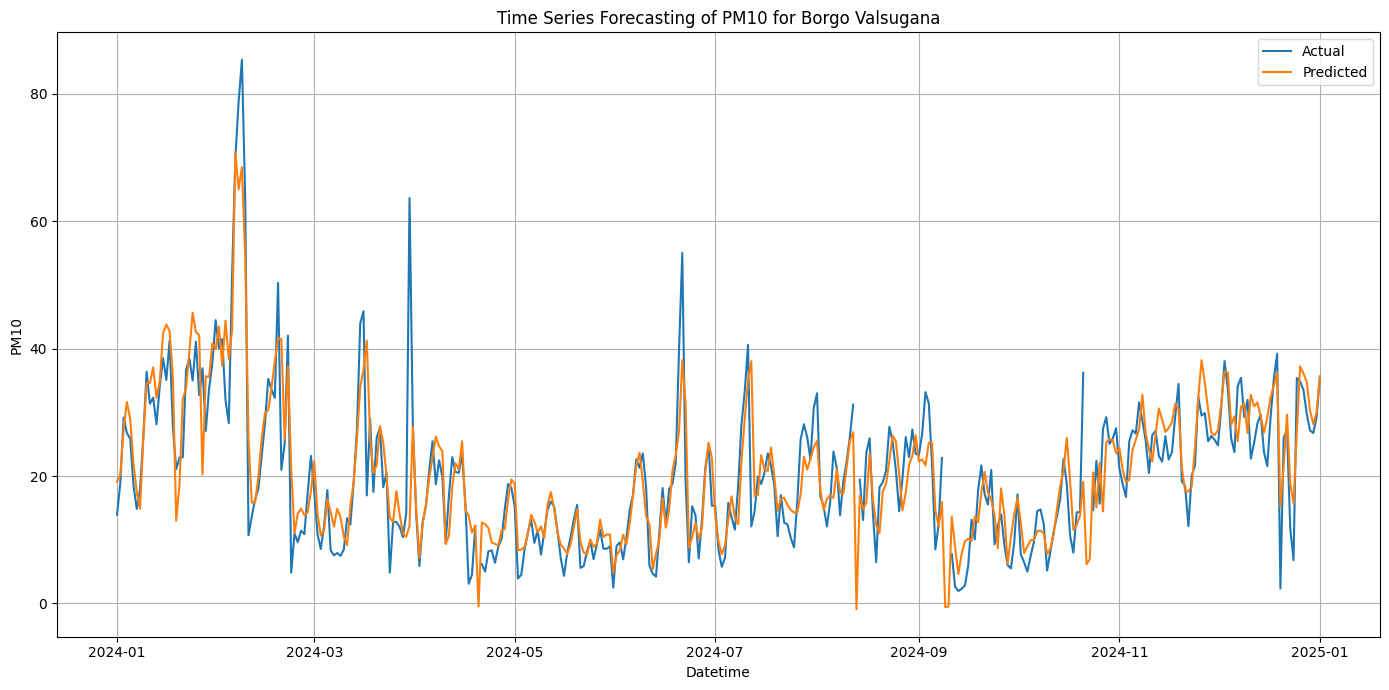

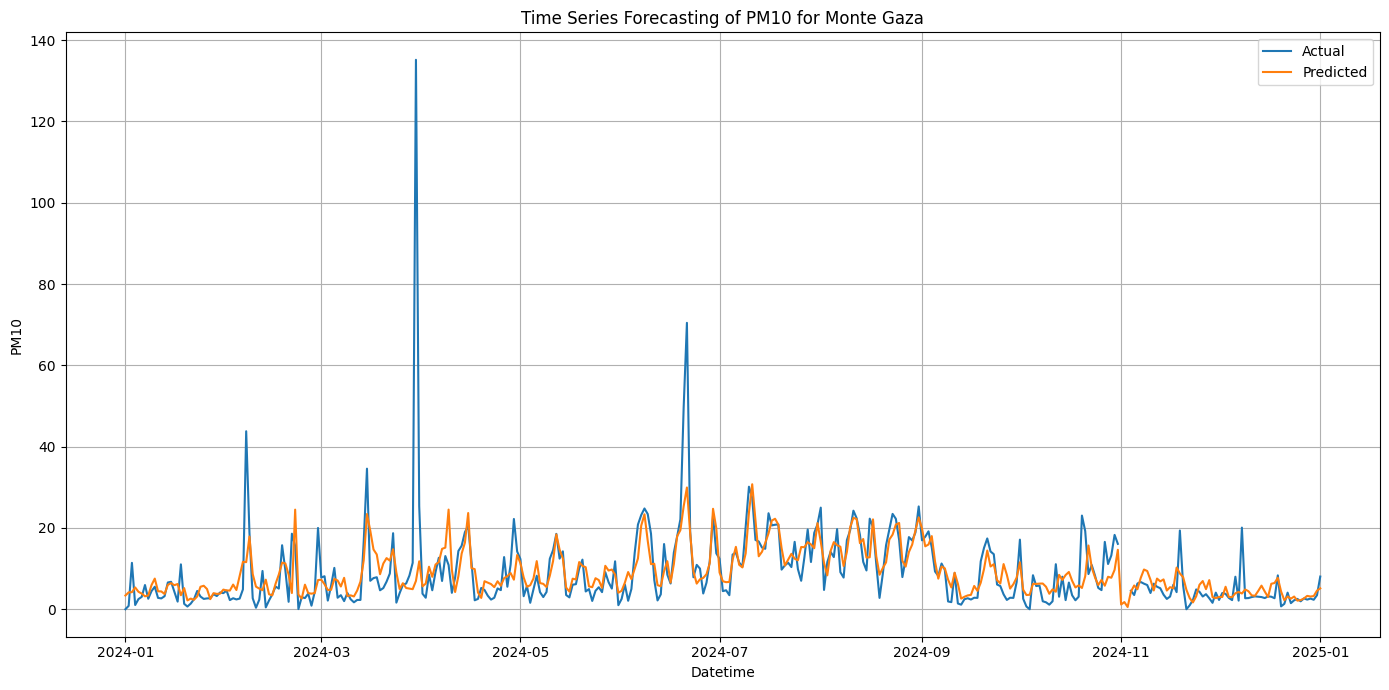

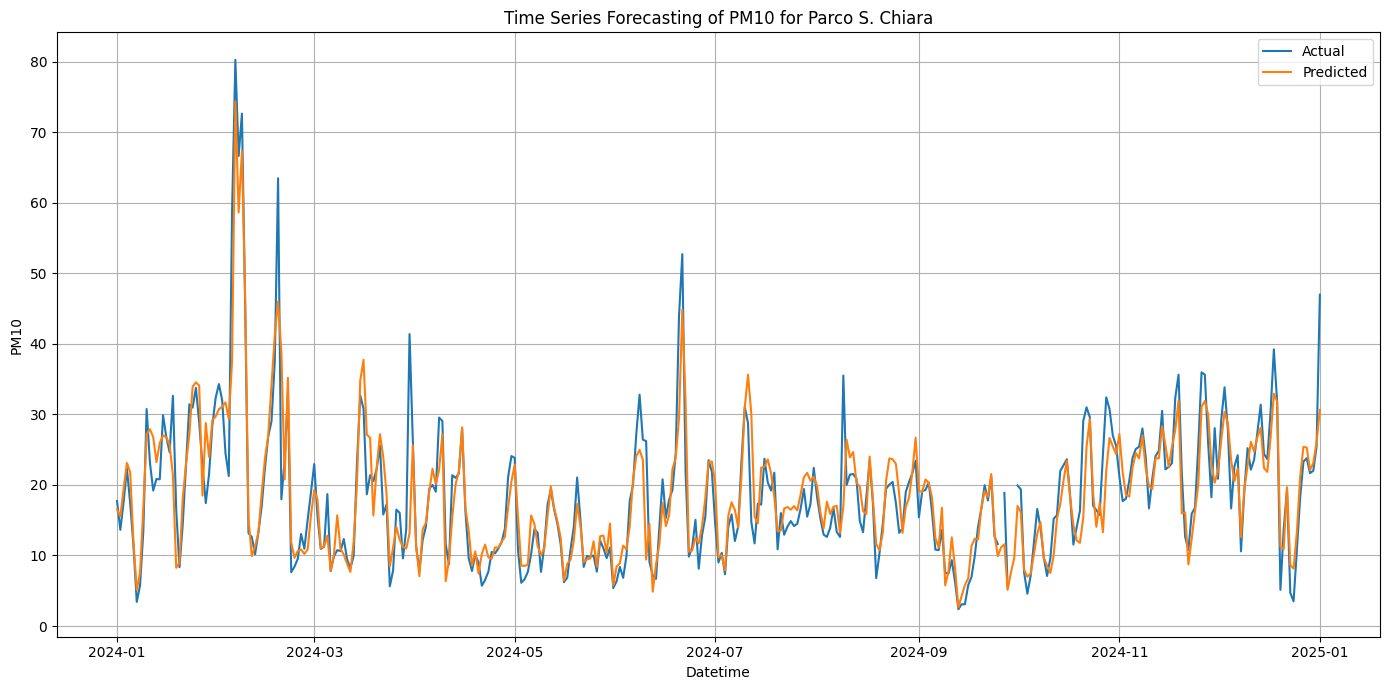

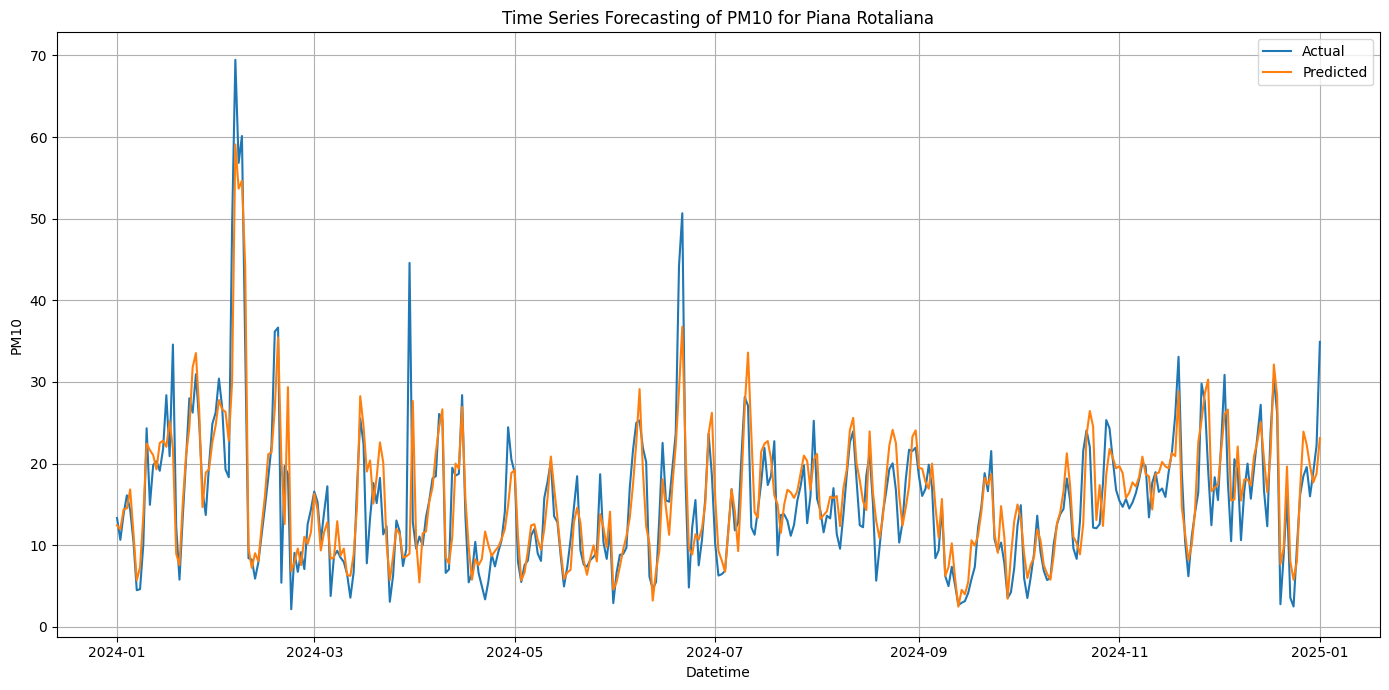

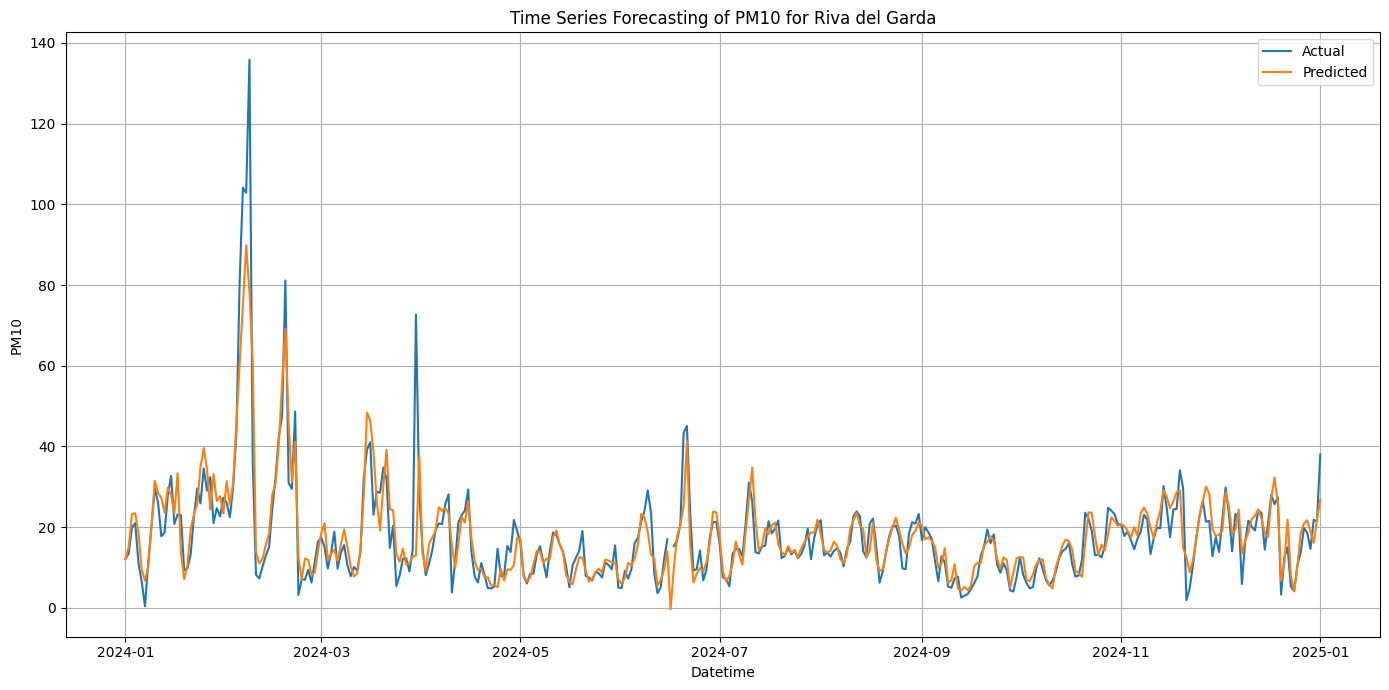

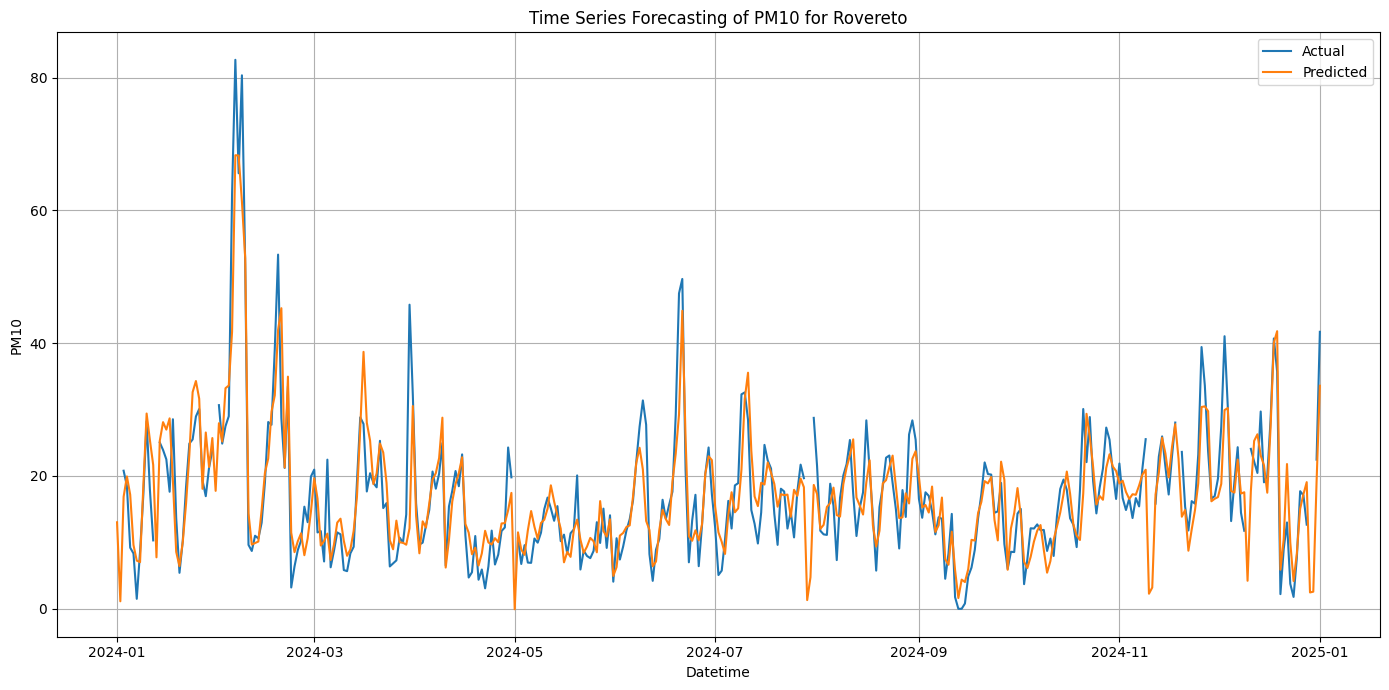

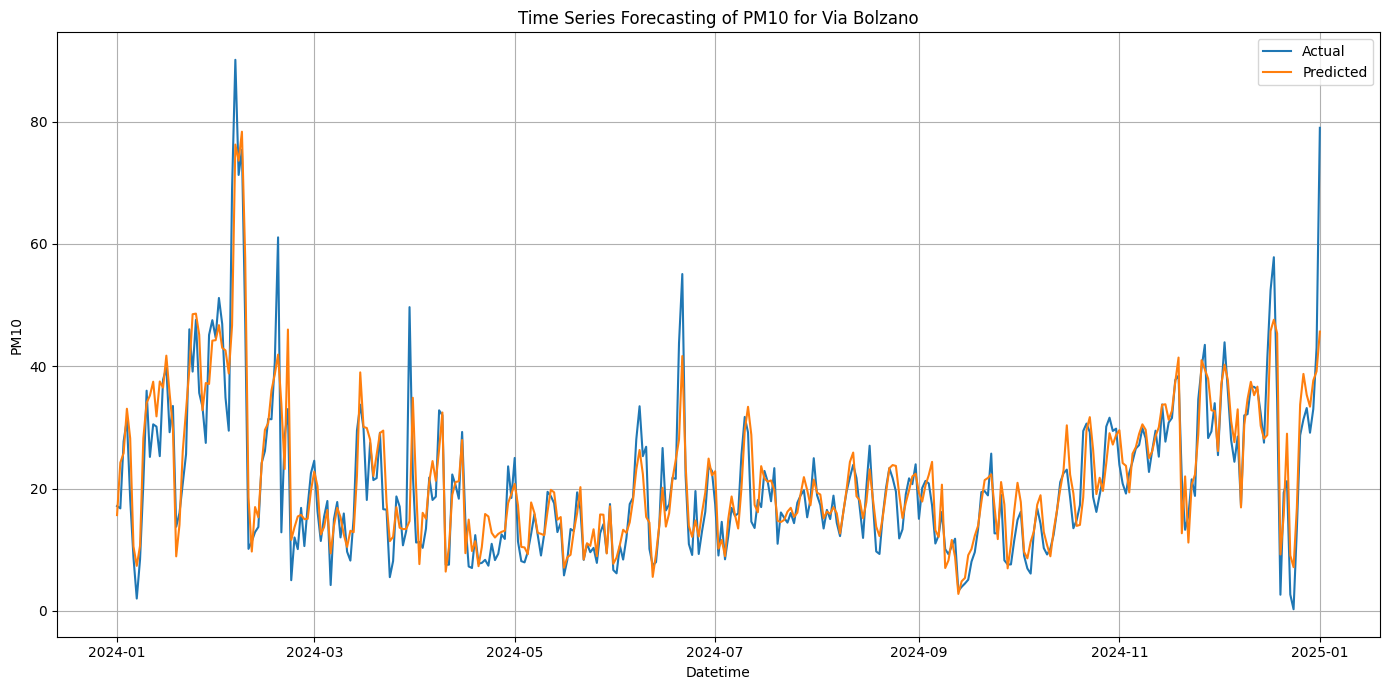

In [268]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate rolling average for smoother visualization
# window_size = 24 * 7 # 7 days rolling average

for station in stations_dfs.keys():
    y_test_station = y_test_dfs[station]
    predictions_station = predictions_dfs[station]
    test_station_df = test_dfs[station] # Get the original test dataframe for the index

    # Calculate rolling average for smoother visualization
    # y_test_rolling = y_test_station['PM10'].rolling(window=window_size).mean()
    # predictions_rolling = pd.Series(predictions_station, index=test_station_df.index).rolling(window=window_size).mean()


    plt.figure(figsize=(14, 7))
    plt.plot(test_station_df.index, y_test_station[f'{station}_PM10'], label='Actual')
    plt.plot(test_station_df.index, predictions_station, label='Predicted')

    plt.xlabel("Datetime")
    plt.ylabel("PM10")
    plt.title(f"Time Series Forecasting of PM10 for {station}")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


Calculating SHAP values for A22 (Avio)...
Generating SHAP summary plot for A22 (Avio)...


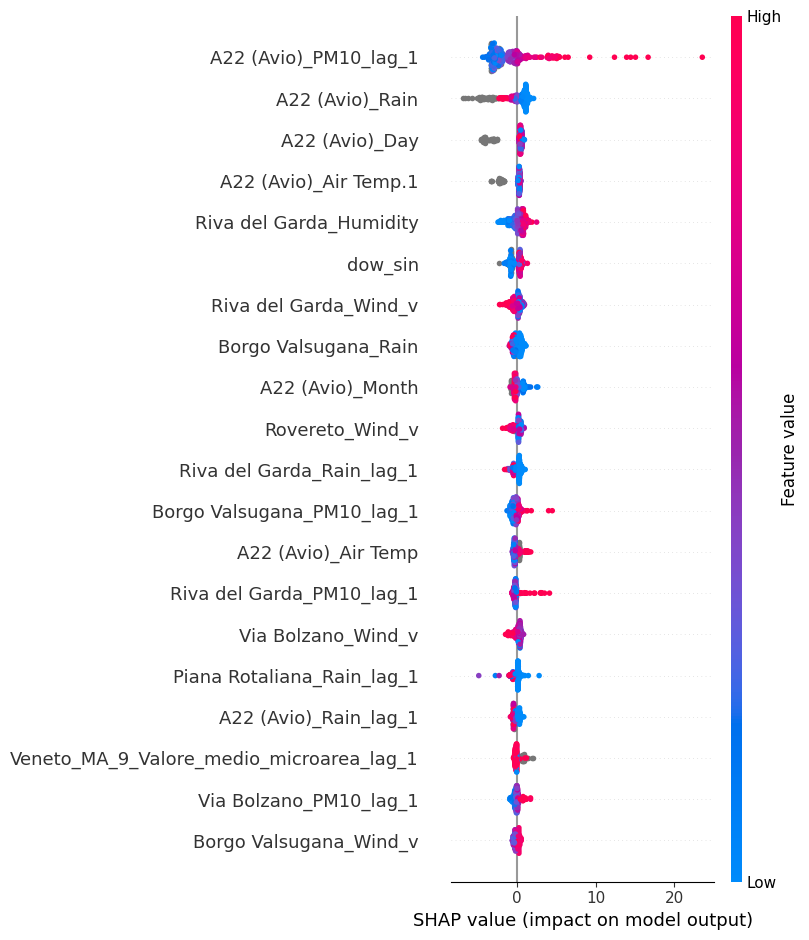


Calculating SHAP values for Borgo Valsugana...
Generating SHAP summary plot for Borgo Valsugana...


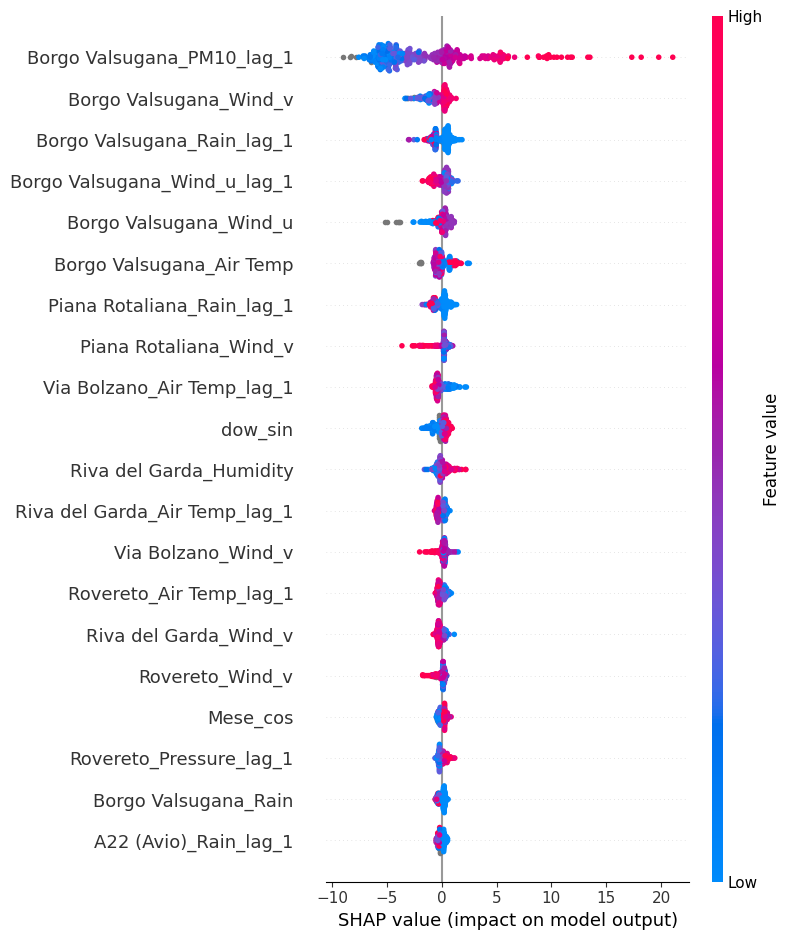


Calculating SHAP values for Monte Gaza...
Generating SHAP summary plot for Monte Gaza...


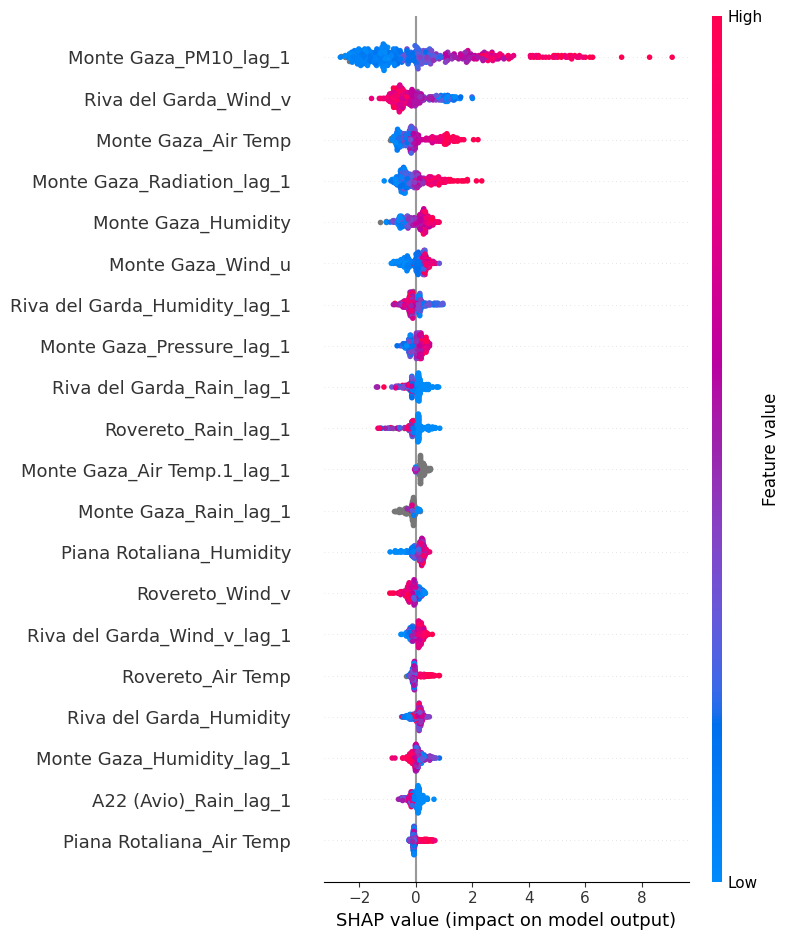


Calculating SHAP values for Parco S. Chiara...
Generating SHAP summary plot for Parco S. Chiara...


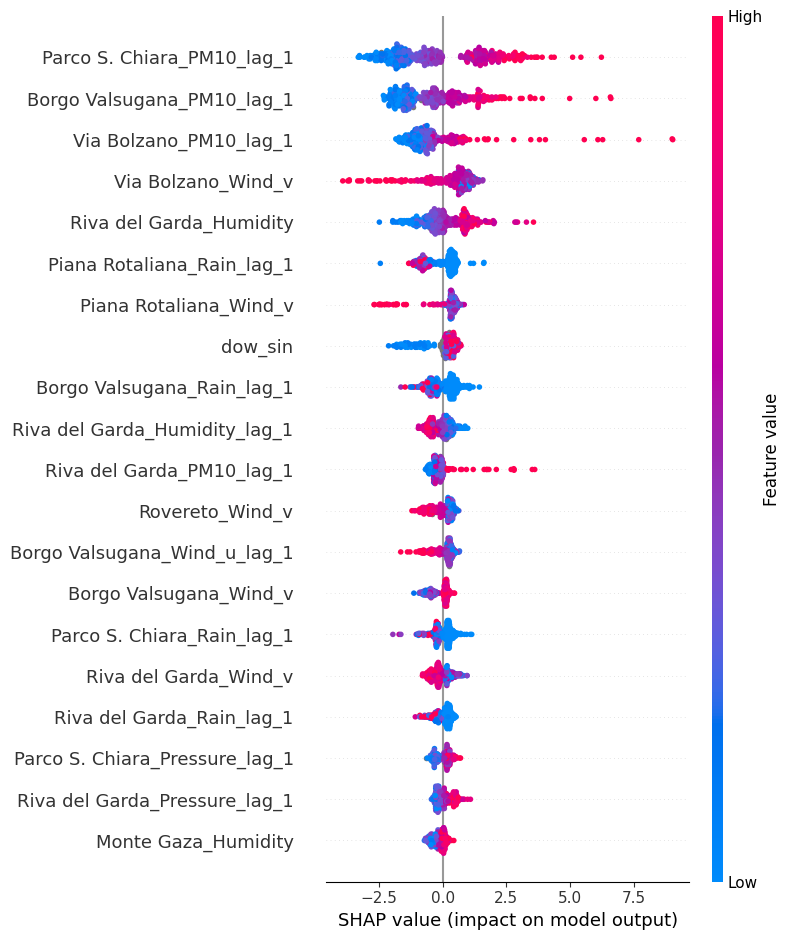


Calculating SHAP values for Piana Rotaliana...
Generating SHAP summary plot for Piana Rotaliana...


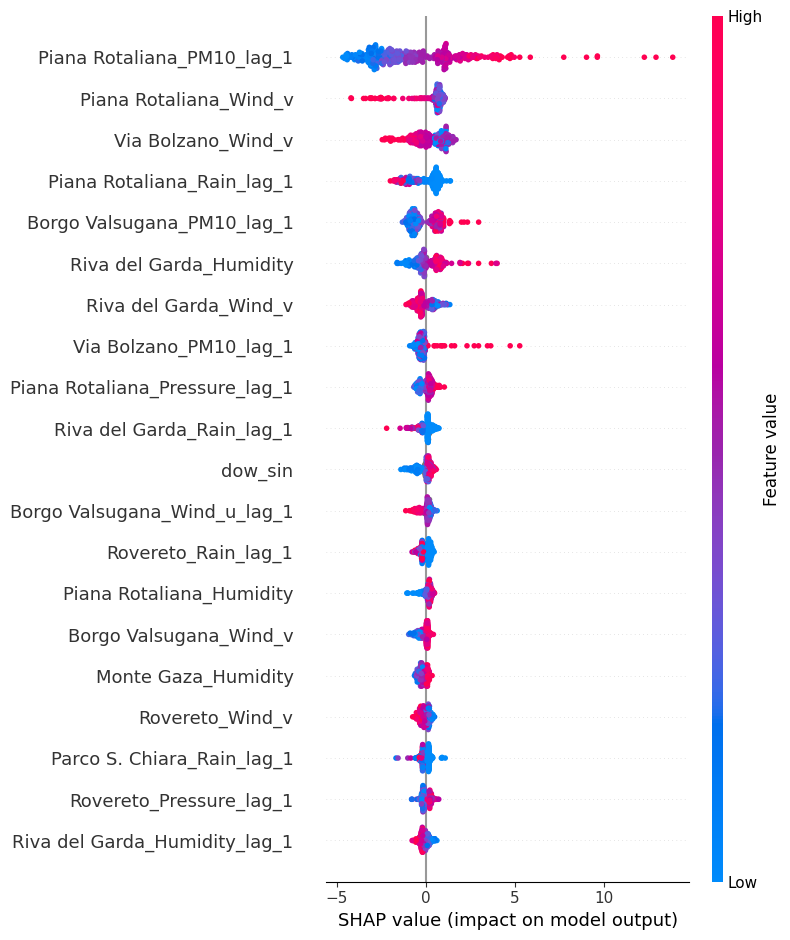


Calculating SHAP values for Riva del Garda...
Generating SHAP summary plot for Riva del Garda...


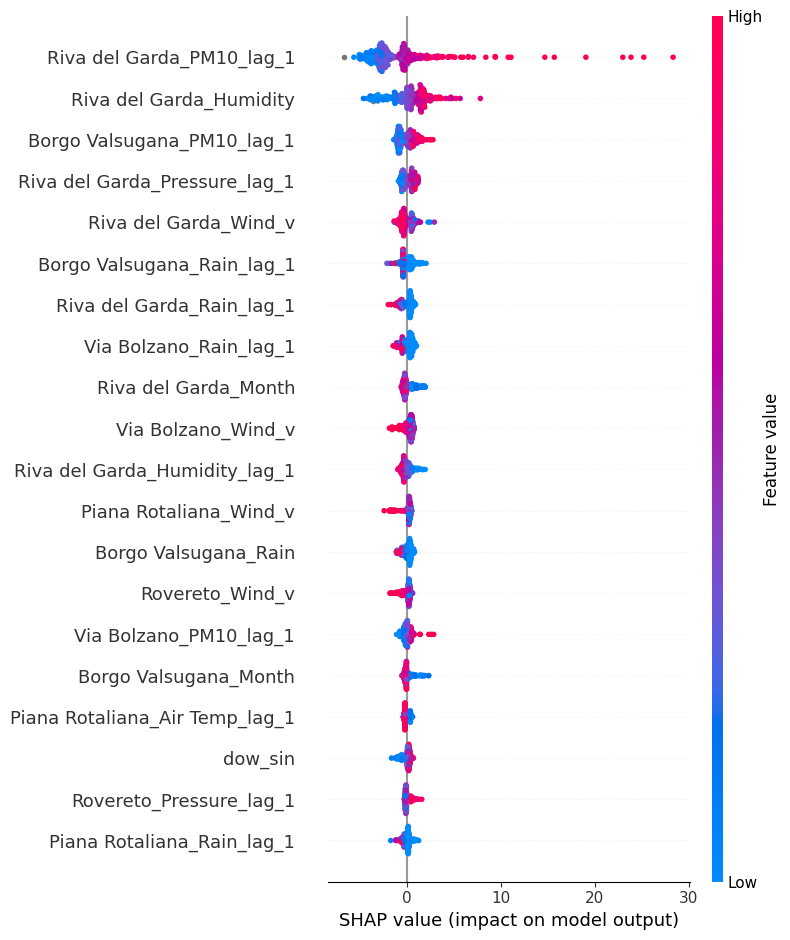


Calculating SHAP values for Rovereto...
Generating SHAP summary plot for Rovereto...


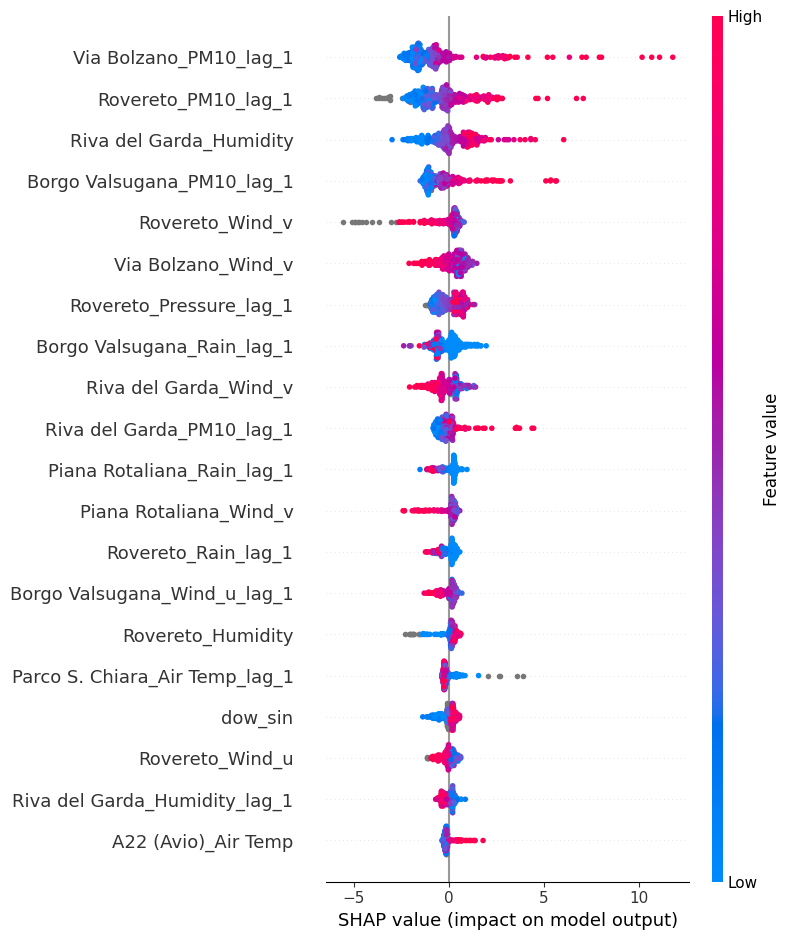


Calculating SHAP values for Via Bolzano...
Generating SHAP summary plot for Via Bolzano...


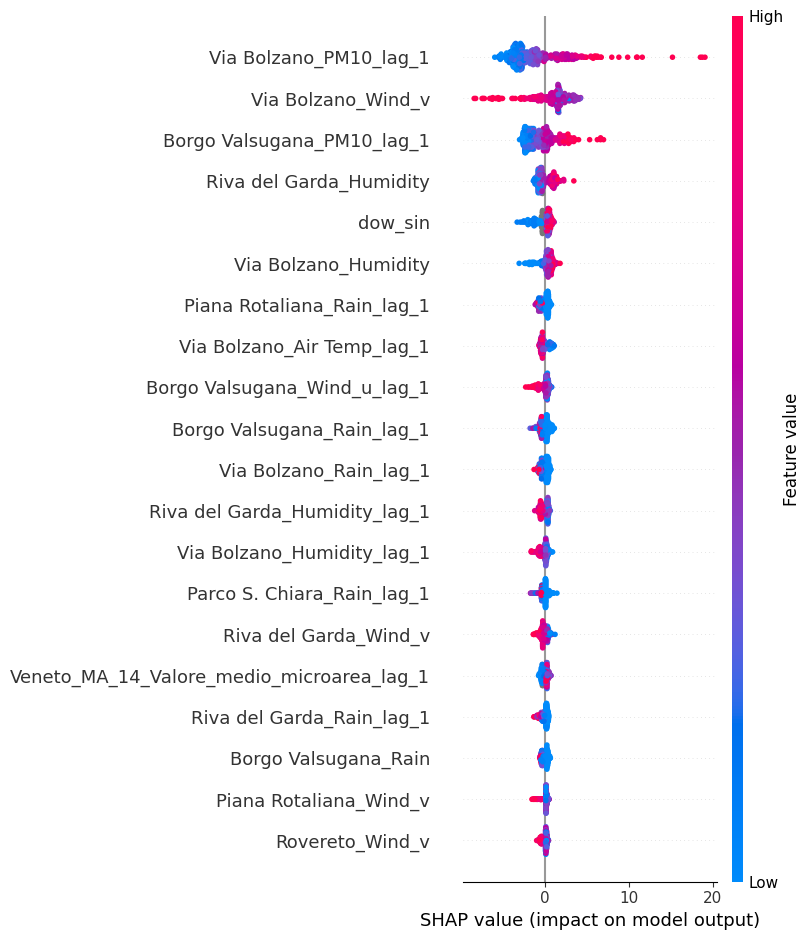


SHAP analysis complete for all stations.


In [269]:
import shap

for station, model in trained_models.items():
    print(f"\nCalculating SHAP values for {station}...")
    # crea explainer
    explainer = shap.TreeExplainer(model, data=X_train_dfs[station], feature_perturbation="interventional")

    # calcola shap values su un campione di test (o su tutto, in batch)
    X_to_explain = X_test_dfs[station].sample(n=min(2000, len(X_test_dfs[station])), random_state=0)  # campione per plotting
    shap_values = explainer(X_to_explain, check_additivity=False)  # questo è veloce per TreeExplainer
    # shap_values.values è array (n_samples, n_features)

    # sv = pd.DataFrame(shap_values.values, columns=X_to_explain.columns, index=X_to_explain.index)
    # base_values = shap_values.base_values  # shape (n_samples,) o scalar

    print(f"Generating SHAP summary plot for {station}...")
    shap.summary_plot(shap_values.values, X_to_explain, feature_names=X_to_explain.columns)
    # oppure summary_plot(shap_values) con versione più recente di shap

print("\nSHAP analysis complete for all stations.")